In [1]:
import pickle
import pandas as pd
import lightgbm as lgb

In [2]:
print_to_file = False 
test_run = False 
param_set = 'bo2'  # simple

train = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/fe_selected/train_0827.pkl')
test = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/fe_selected/test_0827.pkl')
# train = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/op5_train_fold0.pkl')
# test = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/op5_test_fold0.pkl')
# fe_id = 'comb_936'
# train = pd.read_pickle('/home/kai/data/shiyi/homecreditdata /op5_test_fold4.pkl op5_train_fold4.pkl')
# test = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/op5_test_fold4.pkl')
# fe_id = 'op5f4'

In [3]:
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
test['SK_ID_CURR'] = test['SK_ID_CURR'].astype(int)

In [4]:
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']

# main func

In [25]:
from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None, mode='sklearn', max_bin=255):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
        
        
    # compute optimal rounds
    lgb_params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': lr,
        'max_bin': max_bin,
        'min_data_in_leaf': min_child_samples,
        'num_leaves': num_leaves, 
        'num_threads': 18, 
        'max_depth': max_depth,
        'min_child_weight': 39,
        'feature_fraction': colsample,
        'feature_fraction_seed': seed,
        'bagging_fraction': subsample, 
        'bagging_seed': seed,
        'scale_pos_weight': 1,
        'lambda_l1': 0.65, 
        'lambda_l2': reg_lambda,
#         'device': 'GPU',
        'metric': 'auc'
    }
    if rounds is None:
        print('computing optimal rounds...')
        lgb_train = lgb.Dataset(train_df.drop(columns=['TARGET','SK_ID_CURR']), label=train_df['TARGET'])

        eval_hist = lgb.cv(lgb_params, lgb_train, nfold=num_folds, stratified=stratified, 
                           num_boost_round=50000, early_stopping_rounds=200, verbose_eval=verbose)
        best_round = len(eval_hist['auc-mean'])
        rounds = best_round
        print('lgb cv: ', eval_hist['auc-mean'][-1], ' std: ', eval_hist['auc-stdv'][-1])
        print('best rounds: ', rounds)

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        if mode=='sklearn':
            clf = LGBMClassifier(
                nthread=18,
                n_estimators=30000,
                learning_rate=lr,
                num_leaves=num_leaves,
                colsample_bytree=colsample, # 0.67
                subsample=subsample,
                subsample_freq=0, ## disable subsampling
                max_depth=max_depth,
                reg_alpha=0.65,
                reg_lambda=reg_lambda,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                min_child_samples=min_child_samples,
                silent=-1,
                verbose=-1, )
            if rounds is not None:
                clf.n_estimators = rounds
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= 'auc', verbose=verbose)
                oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
            else:
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
                oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 

            train_score = clf.best_score_['training']['auc']
         
    
        else:
            lgb_params['device'] = 'GPU'
            lgb_train = lgb.Dataset(train_x, label=train_y)
            lgb_val = lgb.Dataset(valid_x, label=valid_y)
            lgb_model = lgb.train(lgb_params, train_set=lgb_train, valid_sets=[lgb_train, lgb_val], 
                                  num_boost_round=rounds, verbose_eval=verbose)
            oof_preds[valid_idx] = lgb_model.predict(valid_x)
            sub_preds += lgb_model.predict(test_df[feats]) / folds.n_splits
            holdout_preds = lgb_model.predict(holdout[feats])
            
            train_score = lgb_model.best_score['training']['auc'] 
        
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds #if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)

        fold_importance_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
        else:
            fold_importance_df['feature'] = lgb_model.feature_name() 
            fold_importance_df["importance"] = lgb_model.feature_importance() 
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_importance_gain_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_gain_df["feature"] = feats
            fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        else:
            fold_importance_gain_df['feature'] = lgb_model.feature_name() 
            fold_importance_gain_df["importance"] = lgb_model.feature_importance(importance_type='gain') 
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)


#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % roc_auc_score(holdout['TARGET'], holdout_final_preds))
    print('FULL HO mean {:.6f}, std {:.6f}'.format(np.mean(holdout_scores), np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(np.mean(scores), np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(np.mean(train_scores), np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     if not print_to_file:
#         display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df, oof_preds 
        
#                 min_split_gain=0.0222415,

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [27]:
def runlgb(train, test, holdout):
    colsamples = [0.7]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
    seeds = [20]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
    depth = [9]
    leaves = [27]
    min_child_sam = [220]#, 800]
    subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
    reg_lambdas = [1]
    # lrs = lrs.tolist()
    lrs2 = [0.1]
    nfolds = 5 
    rounds = [None] #[1000]#, 1300, 1600, 1900, 2200, 2500]
    for seed in seeds:
        for colsample in colsamples:
            for d in depth:
                for l in leaves:
                    for mcs in min_child_sam:
                        for subsample in subsamples:
                            for reg_lambda in reg_lambdas:
                                for lr in lrs2:
                                    for r in rounds:
                                        filename = 'fe_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                        print('#############################################')
                                        print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                        print('#############################################')
                                        numfeats = len(train.columns)
                                        with timer("Run LightGBM with kfold"):
    #                                         return kfold_lightgbm_ori(None, train, test, 5, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True)
                                            return kfold_lightgbm(None, train, test, holdout, nfolds, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True, rounds=r, mode='lgb', max_bin=255)

In [7]:
train_df, holdout_df = train_test_split(train, test_size=1/7, random_state=4)
print(int(train_df['TARGET'].mean()*10000), int(holdout_df['TARGET'].mean()*10000))

806 810


In [28]:
res = runlgb(train_df, test, holdout_df)

#############################################
0.7 20 9 27 220 1 1 0.1 nfolds: 5
#############################################
(263580, 409) (48744, 409) (43931, 409)
MEAN: train(263580) vs holdout(43931):  0.08067000531148039 0.08108169629646492
computing optimal rounds...
lgb cv:  0.7908676594849715  std:  0.0038215022837672207
best rounds:  274


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  1 [  274] AUC : ho: 0.790944 / te: 0.791591 / tr: 0.883411 (diff: 0.000646)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  2 [  274] AUC : ho: 0.790123 / te: 0.788235 / tr: 0.884354 (diff: 0.001888)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  3 [  274] AUC : ho: 0.790315 / te: 0.795782 / tr: 0.883512 (diff: 0.005467)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  4 [  274] AUC : ho: 0.789160 / te: 0.792347 / tr: 0.883565 (diff: 0.003186)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:722: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  5 [  274] AUC : ho: 0.790457 / te: 0.784402 / tr: 0.884643 (diff: 0.006055)
Full HO score 0.795934
FULL HO mean 0.790200, std 0.000587
FULL TE mean 0.790471, std 0.003868
FULL TR mean 0.883897, std 0.000502
FULL DIFF mean 0.003449, std 0.002060
Run LightGBM with kfold - done in 134s


In [ ]:
Fold  5 
Full HO score 0.796604
FULL HO mean 0.791474, std 0.000320
FULL TE mean 0.792315, std 0.003891
FULL TR mean 0.881558, std 0.000900
FULL DIFF mean 0.003212, std 0.001782
Run LightGBM with kfold - done in 153s

In [ ]:
Fold 10
Full HO score 0.796975
FULL HO mean 0.792990, std 0.000888
FULL TE mean 0.792947, std 0.006723
FULL TR mean 0.867215, std 0.000579

In [ ]:
Fold 20 
Full HO score 0.797845
FULL HO mean 0.793938, std 0.000631
FULL TE mean 0.793792, std 0.007186
FULL TR mean 0.873462, std 0.000298

In [ ]:
Fold 40 
Full HO score 0.797087
FULL HO mean 0.793838, std 0.000642
FULL TE mean 0.793563, std 0.010366
FULL TR mean 0.862567, std 0.000319

In [ ]:
#############################################
0.3 20 5 16 20 1 0.5 0.1 nfolds: 5
#############################################
(263580, 936) (48744, 935) (43931, 936)
MEAN: train(263580) vs holdout(43931):  0.08067000531148039 0.08108169629646492
computing optimal rounds...
lgb cv:  0.792242828777376  std:  0.0029334029719040922
best rounds:  417
Fold  1 [  417] AUC : ho: 0.790531 / te: 0.792561 / tr: 0.864087 (diff: 0.002030)
Fold  2 [  417] AUC : ho: 0.791099 / te: 0.791632 / tr: 0.864715 (diff: 0.000533)
Fold  3 [  417] AUC : ho: 0.790679 / te: 0.795254 / tr: 0.862829 (diff: 0.004575)
Fold  4 [  417] AUC : ho: 0.791176 / te: 0.793371 / tr: 0.863838 (diff: 0.002196)
Fold  5 [  417] AUC : ho: 0.791791 / te: 0.786357 / tr: 0.864490 (diff: 0.005433)
Full HO score 0.795562
FULL HO mean 0.791055, std 0.000441
FULL TE mean 0.791835, std 0.002987
FULL TR mean 0.863992, std 0.000657
FULL DIFF mean 0.002954, std 0.001792
Run LightGBM with kfold - done in 546s

#############################################
0.3 20 5 16 20 1 0.5 0.1 nfolds: 5
#############################################
(263580, 1297) (48744, 1297) (43931, 1297)
MEAN: train(263580) vs holdout(43931):  0.08067000531148039 0.08108169629646492
computing optimal rounds...
lgb cv:  0.7920496715762197  std:  0.0032030625650333036
best rounds:  515
Fold  1 [  515] AUC : ho: 0.791717 / te: 0.792932 / tr: 0.875505 (diff: 0.001215)
Fold  2 [  515] AUC : ho: 0.790675 / te: 0.791354 / tr: 0.875843 (diff: 0.000679)
Fold  3 [  515] AUC : ho: 0.790910 / te: 0.796542 / tr: 0.874991 (diff: 0.005632)
Fold  4 [  515] AUC : ho: 0.791927 / te: 0.793368 / tr: 0.876322 (diff: 0.001442)
Fold  5 [  515] AUC : ho: 0.791327 / te: 0.785688 / tr: 0.876527 (diff: 0.005639)
Full HO score 0.796507
FULL HO mean 0.791311, std 0.000471
FULL TE mean 0.791977, std 0.003567
FULL TR mean 0.875838, std 0.000555
FULL DIFF mean 0.002922, std 0.002230
Run LightGBM with kfold - done in 838s

In [21]:
lgb_train = lgb.Dataset(train_df.drop(columns=['TARGET']), label=train_df['TARGET'])

In [57]:
eval_hist = lgb.cv(lgb_params, lgb_train_p, nfold=5, stratified=True, num_boost_round=1000, early_stopping_rounds=200, verbose_eval=50)

[50]	cv_agg's auc: 0.753158 + 0.00712546
[100]	cv_agg's auc: 0.750716 + 0.0116197
[150]	cv_agg's auc: 0.746971 + 0.0131305
[200]	cv_agg's auc: 0.742751 + 0.0131259
[250]	cv_agg's auc: 0.739963 + 0.0119346


# Feature selection

## 1. preparation

In [7]:
if test_run:
    train = train.head(10000)
    test = test.head(3000)

cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)
train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

## 2. Remove Collinear Variables

In [58]:
def corr_drop(train, test):
    # Absolute value correlation matrix
    corr_matrix = train.corr().abs()
    # corr_matrix.head()
    # Upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # upper.head()
    pickle.dump(upper, open('upper.pkl', 'wb'))
    upper = pickle.load(open('upper.pkl','rb'))
    # Threshold for removing correlated variables
    threshold = 0.9
    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print('There are %d columns to remove.' % (len(to_drop)))
    train = train.drop(columns = to_drop)
    test = test.drop(columns = to_drop)
    print('Training shape: ', train.shape)
    print('Testing shape: ', test.shape)
    print('start corr removed ###################')
    return train, test

In [64]:
upper = pickle.load(open('upper.pkl','rb'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [ ]:
train, test = corr_drop(train, test)

In [60]:
train.shape

(307511, 946)

In [61]:
test.shape

(48744, 945)

In [66]:
train.to_pickle('/home/kai/data/shiyi/homecreditdata/train_bo2_imp0_corr9_cols945.pkl')
test.to_pickle('/home/kai/data/shiyi/homecreditdata/test_bo2_imp0_corr9_cols945.pkl')

## 3. LGB start 

## 3. Remove Missing Values

In [21]:
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
# train_missing.head()

# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
# test_missing.head()

ms_thresh = 0.9
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > ms_thresh]
test_missing = test_missing.index[test_missing > ms_thresh]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are {} columns with more than {} missing values'.format(len(all_missing), ms_thresh))

There are 0 columns with more than 0.9 missing values


## 4. Feature Selection through Feature Importances

In [12]:
s_imp, g_imp, train_preds = res

In [13]:
# Find the features with zero importance
zero_features_split = list(s_imp[s_imp['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features_split))
# feature_importances.tail()

There are 0 features with 0.0 importance


In [14]:
# Find the features with zero importance
zero_features_gain = list(g_imp[g_imp['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features_gain))
# feature_importances.tail()

There are 0 features with 0.0 importance


In [15]:
s_imp.head()

,feature,importance
0,AMT_CREDIT_divide_AMT_ANNUITY,76.0
1,external_sources_min,49.0
2,DAYS_BIRTH_x,47.2
3,EXT_SOURCE_2_x,34.6
4,AMT_CREDIT_divide_AMT_GOODS_PRICE,34.6


In [23]:
train_missing_df = train_missing.reset_index().rename(columns={'index':'feature', 0:'miss_perc'})

In [24]:
s_imp_missing = s_imp.merge(train_missing_df, how='left')

In [97]:
s_imp_missing.head(10)

,feature,importance,miss_perc
0,AMT_CREDIT_divide_AMT_ANNUITY,76.0,0.000039
1,external_sources_min,49.0,0.000559
2,DAYS_BIRTH_x,47.2,0.000000
3,EXT_SOURCE_2_x,34.6,0.002146
4,AMT_CREDIT_divide_AMT_GOODS_PRICE,34.6,0.000904
5,external_sources_max,33.6,0.000559
6,bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DE...,32.2,0.167087
7,EXT_SOURCE_1_x,27.8,0.563811
8,EXT_SOURCE_3_x,26.8,0.198253
9,NAME_EDUCATION_TYPE_CODE_GENDER_EXT_SOURCE_3_m...,26.6,0.198266


In [39]:
ms_thresh = 0
train_missing_th = train_missing.index[train_missing > ms_thresh]
test_missing_th = test_missing.index[test_missing > ms_thresh]

all_missing = list(set(set(train_missing_th) | set(test_missing_th)))

In [40]:
len(all_missing)

361

In [91]:
from tqdm import tqdm
for col in tqdm(all_missing):
    test['flag_na_'+col] = 0 
    test.loc[test[col].isnull(), 'flag_na_'+col] = 1
    
    train['flag_na_'+col] = 0
    train.loc[train[col].isnull(), 'flag_na_'+col] = 1

100%|██████████| 361/361 [00:43<00:00,  8.30it/s]


In [98]:
from sklearn.preprocessing.imputation import Imputer

In [99]:
im = Imputer()

In [109]:
train_mean = train.copy()
test_mean  = test.copy()

In [108]:
del train_mean, test_mean
gc.collect()

231

In [ ]:
train_mean.fillna()

In [111]:
from tqdm import tqdm
for col in tqdm(all_missing):
    try:
        tr_mean = train_mean[col].mean()
        train_mean[col] = train_mean[col].fillna(tr_mean) #im.fit_transform(train_mean[[col]])
        test_mean[col] = test_mean[col].fillna(tr_mean) #im.fit_transform(test_mean[[col]])
    except:
        print(col)

100%|██████████| 361/361 [00:01<00:00, 303.46it/s]


In [112]:
train.shape, test.shape

((307511, 1297), (48744, 1297))

In [113]:
all_missing[:2]

['OCCUPATION_TYPE_DAYS_BIRTH_mean_abs_diff',
 'creditcard_AMT_PAYMENT_TOTAL_CURRENT_divide_CNT_DRAWINGS_CURRENT_median']

In [33]:
set(zero_features_split) - set(zero_features_gain)

set()

In [ ]:
# len(zero_features)

In [ ]:
if skip_train_nan:
    for col in all_missing:
        zero_features.remove(col)

In [45]:
not_found = []
for col in zero_features_gain: 
    if col not in test:
        not_found.append(col)

In [48]:
zero_features = list(set(zero_features_gain) - set(not_found))

In [49]:
len(zero_features)

444

In [54]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 2234)
Testing shape:  (48744, 2233)


In [39]:
'prev_onehot_NAME_SELLER_INDUSTRY_MLM_partners' in train

False

In [25]:
print('start corr + missing + imp0 removed ###################')
print(train.shape, test.shape)

start corr + missing + imp0 removed ###################
(307511, 2132) (48744, 2132)


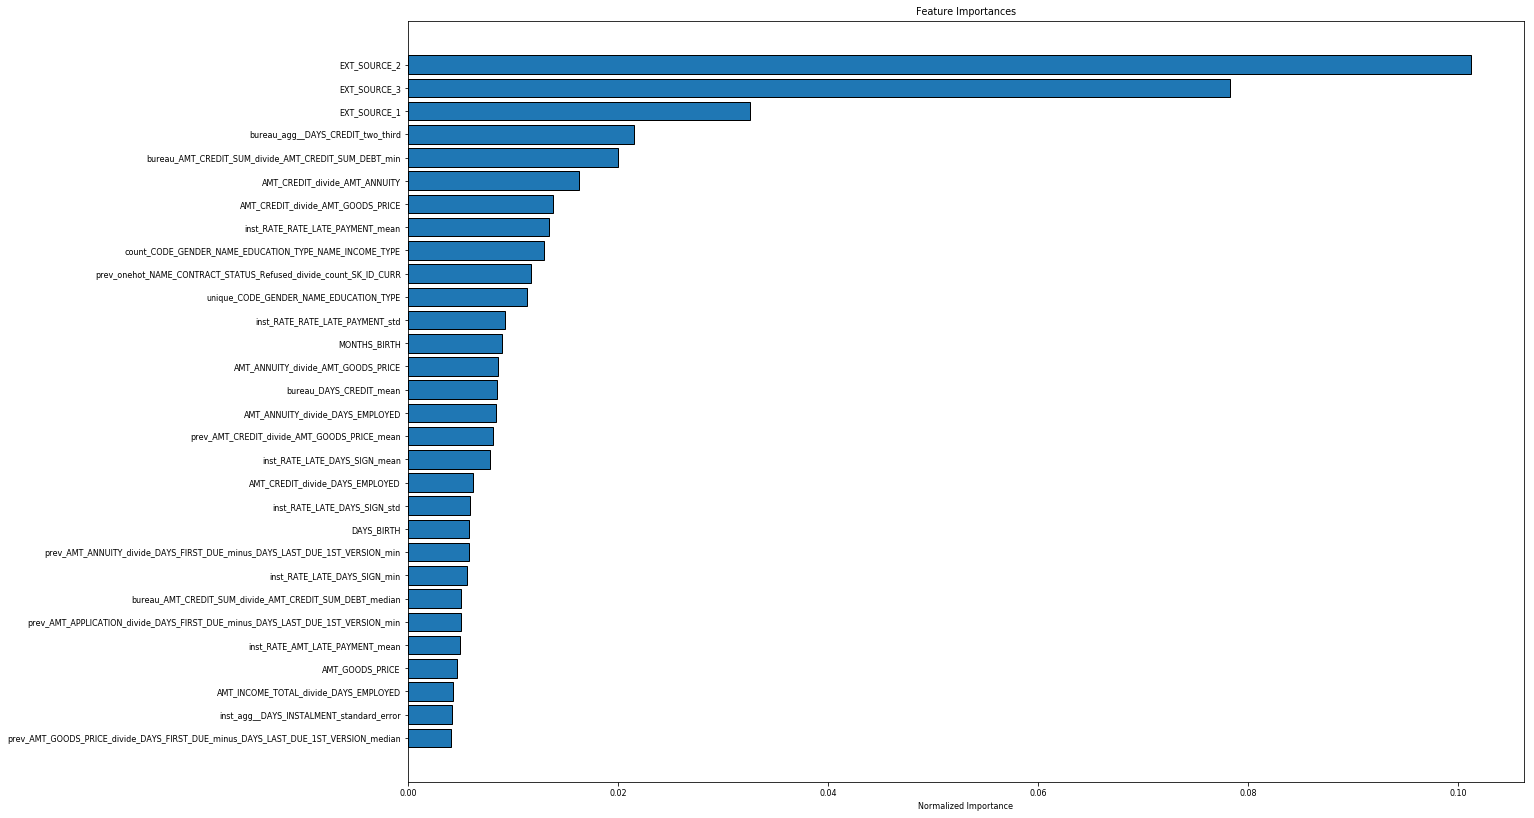

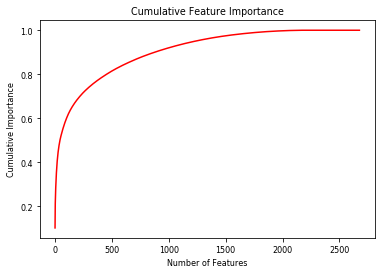

876 features required for 0.90 of cumulative importance


In [31]:
gain_imp_norm = plot_feature_importances(g_imp)

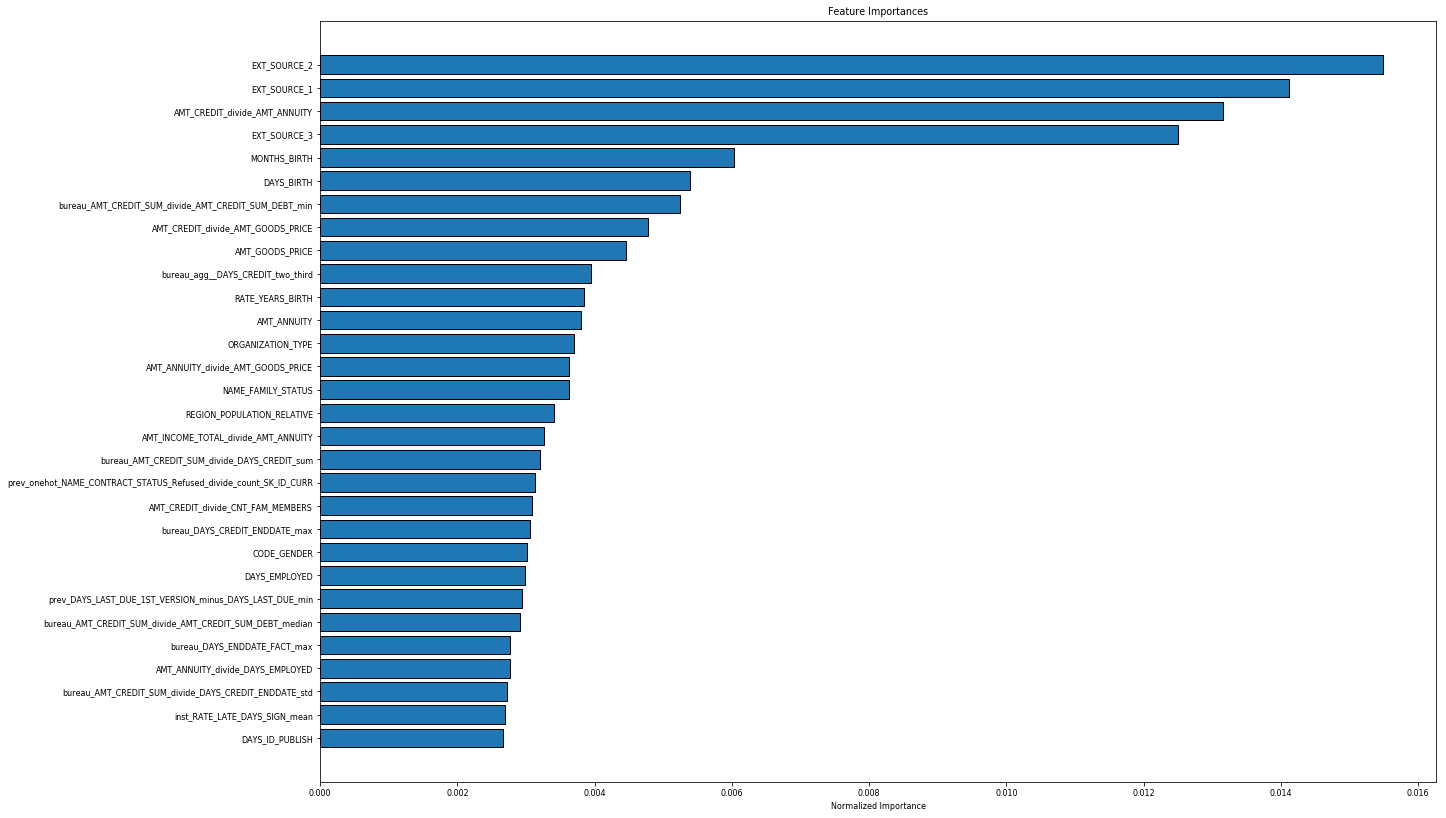

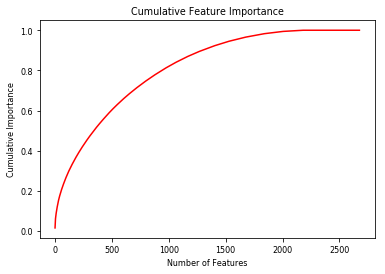

1295 features required for 0.90 of cumulative importance


In [32]:
split_imp_norm = plot_feature_importances(s_imp)

In [30]:
def plot_feature_importances(df, threshold = 0.9, topn=30):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    if not print_to_file:
        plt.rcParams['font.size'] = 8
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (20, 14))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:topn]))), 
                df['importance_normalized'].head(topn), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:topn]))))
        ax.set_yticklabels(df['feature'].head(topn))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
        plt.title('Cumulative Feature Importance');
        plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df